In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
# Download the stopwords dataset
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv('/content/tweet_dataset.csv')

In [4]:
df.head()

,textID,sentiment,author,text,old_text,aux_id,new_sentiment,selected_text
0,1956967341,empty,xoshayzers,i know i was listenin to bad habit earlier a...,@tiffanylue i know i was listenin to bad habi...,p1000000000,NaN,NaN
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,Layin n bed with a headache ughhhh...waitin o...,c811396dc2,negative,headache
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,We want to trade with someone who has Houston...,@dannycastillo We want to trade with someone w...,82565a56d3,neutral,We want to trade with someone who has Houston ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         40000 non-null  int64 
 1   sentiment      40000 non-null  object
 2   author         40000 non-null  object
 3   text           39934 non-null  object
 4   old_text       40000 non-null  object
 5   aux_id         40000 non-null  object
 6   new_sentiment  31395 non-null  object
 7   selected_text  27767 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.4+ MB


In [6]:
df.isnull().sum()

,0
textID,0
sentiment,0
author,0
text,66
old_text,0
aux_id,0
new_sentiment,8605
selected_text,12233


In [7]:
df.columns

Index(['textID', 'sentiment', 'author', 'text', 'old_text', 'aux_id',
       'new_sentiment', 'selected_text'],
      dtype='object')

In [9]:
# Check the actual columns in your DataFrame
print(df.columns)

# Based on the output of the above line, update the list of columns to drop
# For example, if df.columns is ['textID', 'sentiment', 'other_col_1', 'other_col_2', 'other_col_3', 'other_col_4', 'other_col_5', 'other_col_6'],
# and you want to keep 'textID' and 'sentiment', you would drop the other_col_x columns.
# Replace the list below with the correct column names to drop from your df based on print(df.columns)
text_df = df.drop(['textID', 'sentiment'], axis=1) # Example: Dropping 'textID' and 'sentiment' if those are the columns you want to keep. Adjust this list based on df.columns output and what you want to remove.
text_df.head()

Index(['textID', 'sentiment', 'author', 'text', 'old_text', 'aux_id',
       'new_sentiment', 'selected_text'],
      dtype='object')


,author,text,old_text,aux_id,new_sentiment,selected_text
0,xoshayzers,i know i was listenin to bad habit earlier a...,@tiffanylue i know i was listenin to bad habi...,p1000000000,NaN,NaN
1,wannamama,Layin n bed with a headache ughhhh...waitin o...,Layin n bed with a headache ughhhh...waitin o...,c811396dc2,negative,headache
2,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,xkilljoyx,We want to trade with someone who has Houston...,@dannycastillo We want to trade with someone w...,82565a56d3,neutral,We want to trade with someone who has Houston ...


In [10]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

 i know  i was listenin to bad habit earlier and i started freakin at his part =[ 

Layin n bed with a headache  ughhhh...waitin on your call... 

Funeral ceremony...gloomy friday... 

wants to hang out with friends SOON! 

 We want to trade with someone who has Houston tickets, but no one will. 



In [11]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   author         40000 non-null  object
 1   text           39934 non-null  object
 2   old_text       40000 non-null  object
 3   aux_id         40000 non-null  object
 4   new_sentiment  31395 non-null  object
 5   selected_text  27767 non-null  object
dtypes: object(6)
memory usage: 1.8+ MB


In [12]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [14]:
# Download the required NLTK data
import nltk
nltk.download('stopwords')
nltk.download('punkt') # Add this line to download the punkt tokenizer

stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
text_df = text_df.drop_duplicates('text')

In [16]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [21]:
# Download the required NLTK data
import nltk
# Download 'stopwords' and 'punkt' as before
nltk.download('stopwords')
nltk.download('punkt')
# Download the specific 'punkt_tab' resource
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd # Import pandas

stemmer = PorterStemmer()

def stemming(data):
    # Check if the data is a string before attempting to process
    if isinstance(data, str):
        # Tokenize the string into words
        words = data.split() # Or use word_tokenize if you prefer, but split is simpler for this check
        # Apply stemming to each word
        text = [stemmer.stem(word) for word in words]
        # Join the stemmed words back into a string
        return " ".join(text)
    else:
        # If data is not a string (e.g., float/NaN), return an empty string or similar
        return ""

# Apply the data processing function first to clean the text and handle non-string types
text_df['text'] = text_df['text'].apply(lambda x: data_processing(str(x) if pd.notna(x) else ''))

# Now apply the stemming function
text_df['text'] = text_df['text'].apply(lambda x: stemming(x))




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [22]:
text_df.head()

,author,text,old_text,aux_id,new_sentiment,selected_text
0,xoshayzers,know listenin bad habit earlier start freakin ...,@tiffanylue i know i was listenin to bad habi...,p1000000000,NaN,NaN
1,wannamama,layin n bed headach ughhhhwaitin call,Layin n bed with a headache ughhhh...waitin o...,c811396dc2,negative,headache
2,coolfunky,funer ceremonygloomi friday,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,czareaquino,want hang friend soon,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,xkilljoyx,want trade someon houston ticket one,@dannycastillo We want to trade with someone w...,82565a56d3,neutral,We want to trade with someone who has Houston ...


In [23]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

know listenin bad habit earlier start freakin part 

layin n bed headach ughhhhwaitin call 

funer ceremonygloomi friday 

want hang friend soon 

want trade someon houston ticket one 



In [24]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39556 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   author         39556 non-null  object
 1   text           39556 non-null  object
 2   old_text       39556 non-null  object
 3   aux_id         39556 non-null  object
 4   new_sentiment  31015 non-null  object
 5   selected_text  27480 non-null  object
dtypes: object(6)
memory usage: 2.1+ MB


In [25]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [26]:
text_df['polarity'] = text_df['text'].apply(polarity)


In [27]:
text_df.head(10)

,author,text,old_text,aux_id,new_sentiment,selected_text,polarity
0,xoshayzers,know listenin bad habit earlier start freakin ...,@tiffanylue i know i was listenin to bad habi...,p1000000000,NaN,NaN,-0.35
1,wannamama,layin n bed headach ughhhhwaitin call,Layin n bed with a headache ughhhh...waitin o...,c811396dc2,negative,headache,0.00
2,coolfunky,funer ceremonygloomi friday,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy,0.00
3,czareaquino,want hang friend soon,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!,0.00
4,xkilljoyx,want trade someon houston ticket one,@dannycastillo We want to trade with someone w...,82565a56d3,neutral,We want to trade with someone who has Houston ...,0.00
5,xxxPEACHESxxx,repe didnt go prom bc bf didnt like friend,Re-pinging @ghostridah14: why didn't you go to...,a610d6b25b,negative,didn`t like my,0.00
6,ShansBee,sleep im think old friend want he marri want 2...,"I should be sleep, but im not! thinking about ...",p1000000001,NaN,NaN,0.10
7,mcsleazy,hmmm httpwwwdjherocom,Hmmm. http://www.djhero.com/ is down,2dfbe0b7fb,negative,NaN,0.00
8,nic0lepaula,charlen love miss,@charviray Charlene my love. I miss you,cc22eca4c5,negative,Charlene my love. I miss you,0.50
9,Ingenue_Em,im sorri least friday,@kelcouch I'm sorry at least it's Friday?,6d846d7d50,negative,NaN,-0.30


In [28]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [29]:
text_df['sentiment'] = text_df['polarity'].apply(sentiment)

In [30]:
text_df.head()


,author,text,old_text,aux_id,new_sentiment,selected_text,polarity,sentiment
0,xoshayzers,know listenin bad habit earlier start freakin ...,@tiffanylue i know i was listenin to bad habi...,p1000000000,NaN,NaN,-0.35,Negative
1,wannamama,layin n bed headach ughhhhwaitin call,Layin n bed with a headache ughhhh...waitin o...,c811396dc2,negative,headache,0.00,Neutral
2,coolfunky,funer ceremonygloomi friday,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy,0.00,Neutral
3,czareaquino,want hang friend soon,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!,0.00,Neutral
4,xkilljoyx,want trade someon houston ticket one,@dannycastillo We want to trade with someone w...,82565a56d3,neutral,We want to trade with someone who has Houston ...,0.00,Neutral


<Axes: xlabel='sentiment', ylabel='count'>

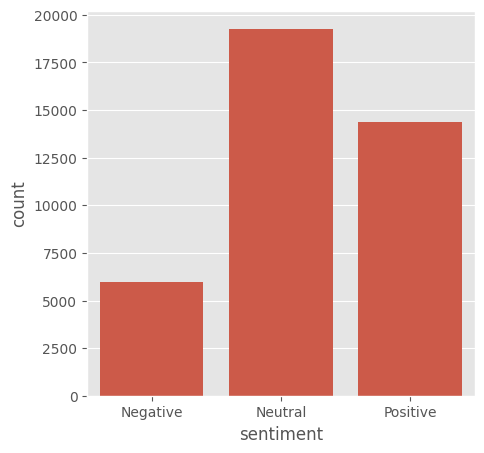

In [31]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = text_df)

Text(0.5, 1.0, 'Distribution of sentiments')

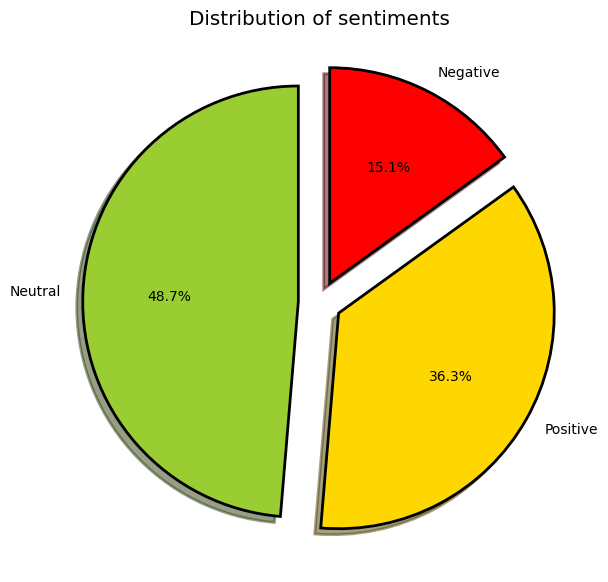

In [32]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')


In [33]:
pos_tweets = text_df[text_df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['polarity'], ascending= False)
pos_tweets.head()

,author,text,old_text,aux_id,new_sentiment,selected_text,polarity,sentiment
34784,kamelperez,battl mina tirith still impress return jedi be...,The battle at Minas Tirith is still very impre...,ba5fe2e423,positive,impressive.,1.0,Positive
39766,natalievass,httptwitpiccom4wukt bought ludi rug dog best,http://twitpic.com/4wukt - We bought Ludi her ...,45b0430eb9,positive,best,1.0,Positive
5165,yolaa,best friend bought someth realli want,my best friends bought something which i reall...,792c97a352,positive,NaN,1.0,Positive
28151,retorta,tempt say twitter best thing sinc slice bread tog,@photojack i am tempted to say that twitter is...,p1000006273,NaN,NaN,1.0,Positive
34421,oasis1223,might middl perfect weekend,Might be in the middle of a perfect weekend...,0025cd3554,positive,perfect,1.0,Positive


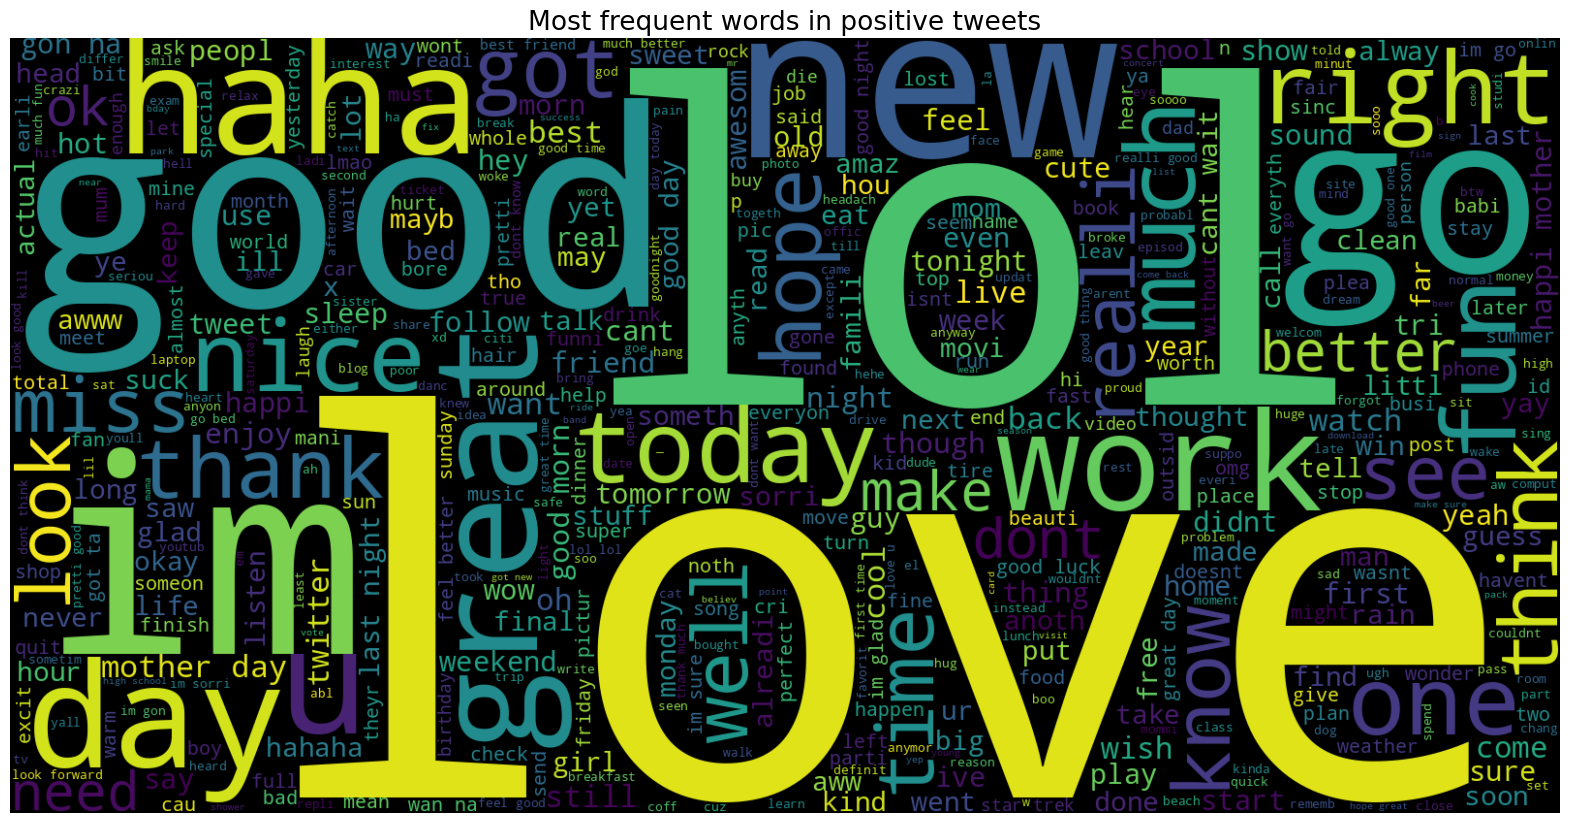

In [34]:
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [35]:
neg_tweets = text_df[text_df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['polarity'], ascending= False)
neg_tweets.head()

,author,text,old_text,aux_id,new_sentiment,selected_text,polarity,sentiment
15963,solen86,saw dead bird way workwhat kind day start poor...,saw a dead bird on my way to work!what a kind ...,e697654ad5,negative,dead bird,-1.850372e-17,Negative
12028,rehabc,twitter spoil fun frustratingli slow couldnt e...,Twitter has spoiled all the fun. Frustratingly...,e77a8f8f2d,negative,NaN,-2.775558e-17,Negative
20698,jodeeee_dancer,green day boulevard broken dream hinder lip an...,"@kyleandjackieo or, Green Day: boulevard of br...",cbb9d08353,positive,NaN,-3.700743e-17,Negative
13421,DawnofOURnight,familyfriend good industri plan go intofar far...,@kirash4 Family...friend... It's good for the ...,1fcd6fd06a,neutral,It`s good for the industry i plan on going int...,-3.700743e-17,Negative
16270,bearylove,ahhhhh hate math right r someth hard learn tod...,@MirandaBuzz ahhhhh....... i hate math!!!!!!! ...,p1000003602,NaN,NaN,-1.488095e-03,Negative


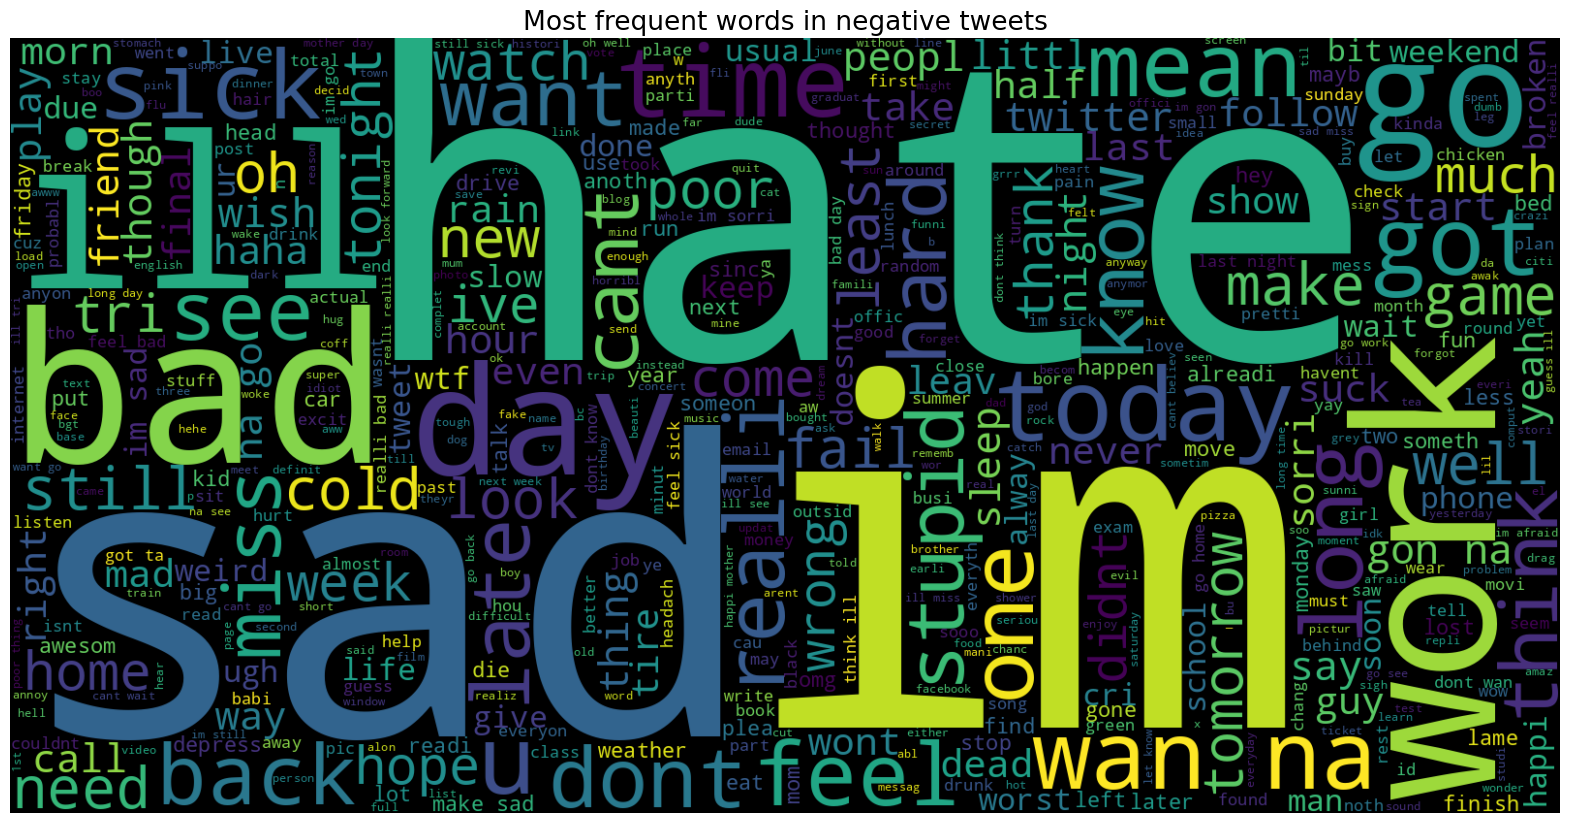

In [36]:
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()


In [37]:
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['polarity'], ascending= False)
neutral_tweets.head()

,author,text,old_text,aux_id,new_sentiment,selected_text,polarity,sentiment
39999,Alpharalpha,bullet train tokyo gf visit japan sinc thursda...,@mopedronin bullet train from tokyo the gf ...,879f64f30d,neutral,bullet train from tokyo the gf and i have b...,0.0,Neutral
1,wannamama,layin n bed headach ughhhhwaitin call,Layin n bed with a headache ughhhh...waitin o...,c811396dc2,negative,headache,0.0,Neutral
2,coolfunky,funer ceremonygloomi friday,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy,0.0,Neutral
3,czareaquino,want hang friend soon,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!,0.0,Neutral
4,xkilljoyx,want trade someon houston ticket one,@dannycastillo We want to trade with someone w...,82565a56d3,neutral,We want to trade with someone who has Houston ...,0.0,Neutral


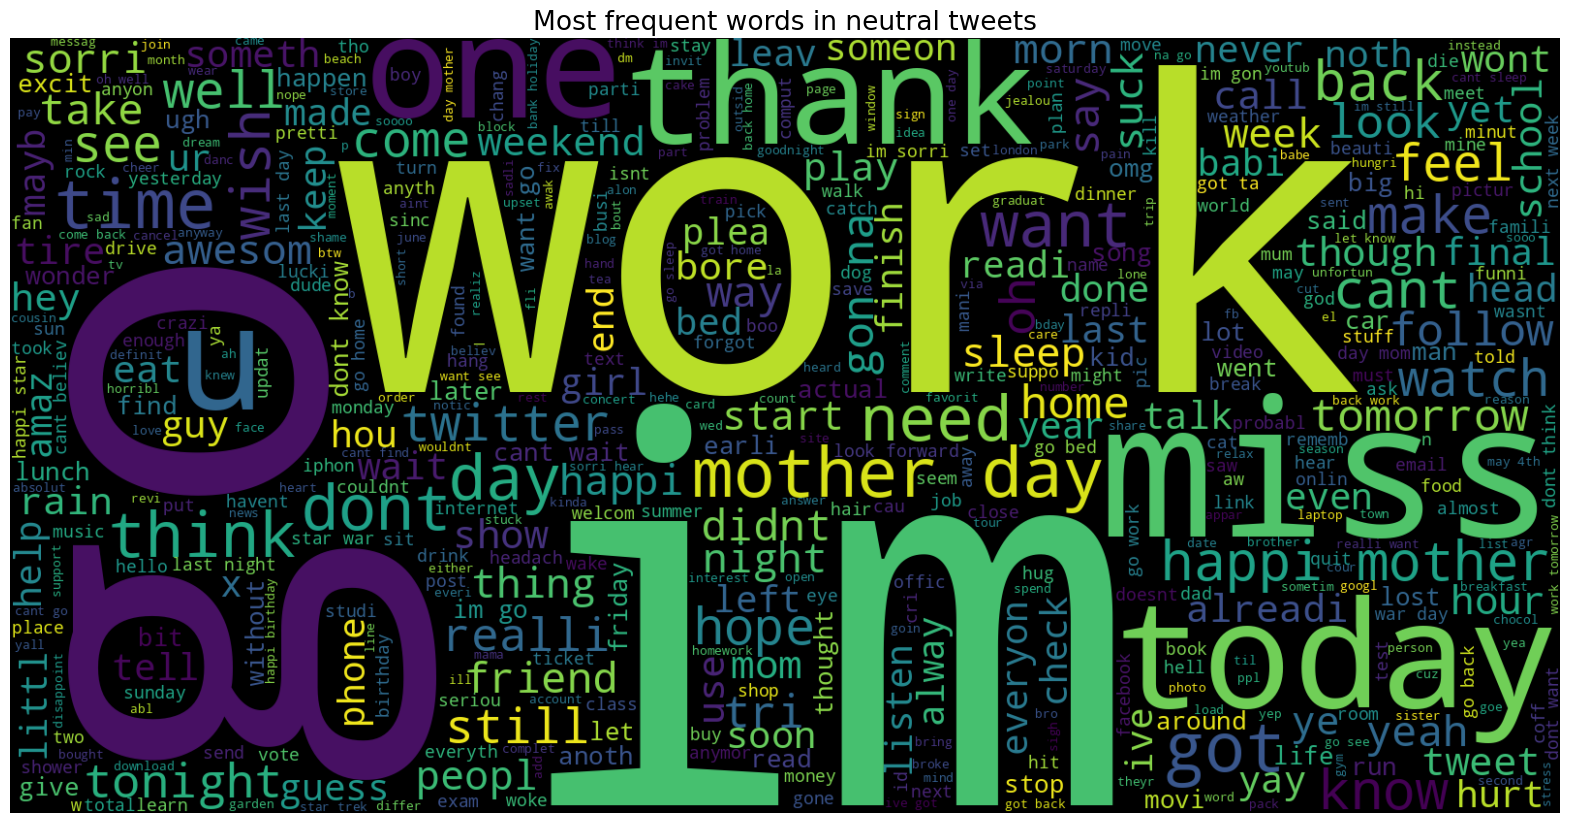

In [38]:
text = ' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

In [39]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['text'])

In [41]:
feature_names = vect.get_feature_names_out() # Changed get_feature_names() to get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 206755

First 20 features:
 ['00' '00 graduat' '000' '000 dunno' '000 httpplurkcompwxj54' '0003'
 '0003 im' '002' '006' '006 total' '01' '01 final' '01 girl' '01 mm' '010'
 '010 050' '0128' '0128 morn' '02' '02 give']


In [42]:
X = text_df['text']
Y = text_df['sentiment']
X = vect.transform(X)

In [43]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [44]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (31644, 206755)
Size of y_train: (31644,)
Size of x_test: (7912, 206755)
Size of y_test: (7912,)


In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 95.69%


In [49]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[ 957  126   53]
 [  12 3807   14]
 [  35  101 2807]]


              precision    recall  f1-score   support

    Negative       0.95      0.84      0.89      1136
     Neutral       0.94      0.99      0.97      3833
    Positive       0.98      0.95      0.97      2943

    accuracy                           0.96      7912
   macro avg       0.96      0.93      0.94      7912
weighted avg       0.96      0.96      0.96      7912



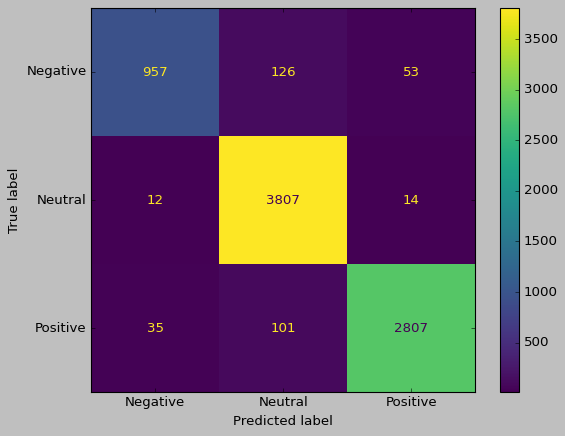

In [50]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
param_grid={'C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [53]:
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 10}


In [54]:
y_pred = grid.predict(x_test)

In [55]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 96.41%


In [56]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[ 981  102   53]
 [  13 3808   12]
 [  27   77 2839]]


              precision    recall  f1-score   support

    Negative       0.96      0.86      0.91      1136
     Neutral       0.96      0.99      0.97      3833
    Positive       0.98      0.96      0.97      2943

    accuracy                           0.96      7912
   macro avg       0.96      0.94      0.95      7912
weighted avg       0.96      0.96      0.96      7912



In [57]:
from sklearn.svm import LinearSVC

In [58]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)

LinearSVC()

In [59]:
svc_pred = SVCmodel.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("test accuracy: {:.2f}%".format(svc_acc*100))

test accuracy: 97.18%


In [60]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[1017   74   45]
 [  15 3807   11]
 [  28   50 2865]]


              precision    recall  f1-score   support

    Negative       0.96      0.90      0.93      1136
     Neutral       0.97      0.99      0.98      3833
    Positive       0.98      0.97      0.98      2943

    accuracy                           0.97      7912
   macro avg       0.97      0.95      0.96      7912
weighted avg       0.97      0.97      0.97      7912



In [61]:
grid = {
    'C':[0.01, 0.1, 1, 10],
    'kernel':["linear","poly","rbf","sigmoid"],
    'degree':[1,3,5,7],
    'gamma':[0.01,1]
}
grid = GridSearchCV(SVCmodel, param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [62]:
print("Best parameter:", grid.best_params_)

Best parameter: {'C': 10}


In [63]:
y_pred = grid.predict(x_test)

In [64]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 97.26%


In [65]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[1018   73   45]
 [  17 3807    9]
 [  27   46 2870]]


              precision    recall  f1-score   support

    Negative       0.96      0.90      0.93      1136
     Neutral       0.97      0.99      0.98      3833
    Positive       0.98      0.98      0.98      2943

    accuracy                           0.97      7912
   macro avg       0.97      0.95      0.96      7912
weighted avg       0.97      0.97      0.97      7912

